In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

%load_ext autoreload

In [4]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad


import optax
import torch.utils.data as data
from flax import linen as nn

from functools import partial
import itertools
from tqdm.auto import trange
import matplotlib.pyplot as plt

import pickle

from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)

In [5]:
#### Preparing data
data_dict = pickle.load(open('model_data_dictionary_N_Pa.pkl', 'rb'))


# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

print("After grouping all data together, relevant shapes are:")
print(f"us : {us.shape}")
print(f"ys : {ys.shape}")
print(f"fs : {fs.shape}")
print(f"ws : {ws.shape}")

In total there are 22 distinct membranes.
After grouping all data together, relevant shapes are:
us : (188318, 7)
ys : (188318, 1)
fs : (188318, 1)
ws : (188318, 1)


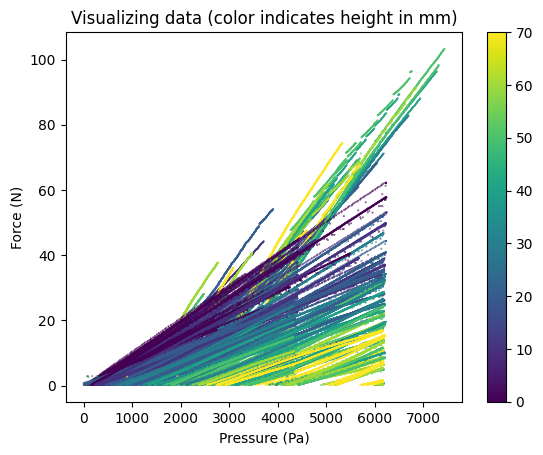

In [6]:
hs = us[:,0]
plt.scatter(ys, fs, c=hs, s=0.1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Force (N)')
plt.colorbar()
plt.title("Visualizing data (color indicates height in mm)")
plt.show()

## Training Model from Data

In [23]:
%autoreload 2
from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

In [24]:
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [25]:
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))

# Define ensemble
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model
print(model.tabulate())

Initializing model...

                                             RPNEnsemble Summary                                              
┌──────────────────────┬───────────────────┬────────────────────┬─────────────────────┬──────────────────────┐
│ path                 │ module            │ inputs             │ outputs             │ params               │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│                      │ RPNEnsemble       │ - float32[10000,7] │ float32[32,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │                      │
├──────────────────────┼───────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ OperatorEnsemble_0   │ OperatorEnsemble  │ - float32[10000,7] │ float32[64,10000,1] │                      │
│                      │                   │ - float32[10000,1] │                     │  

In [26]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [20:34<00:00,  8.10it/s, loss=2.2245917, grad_norm=0.45291394]


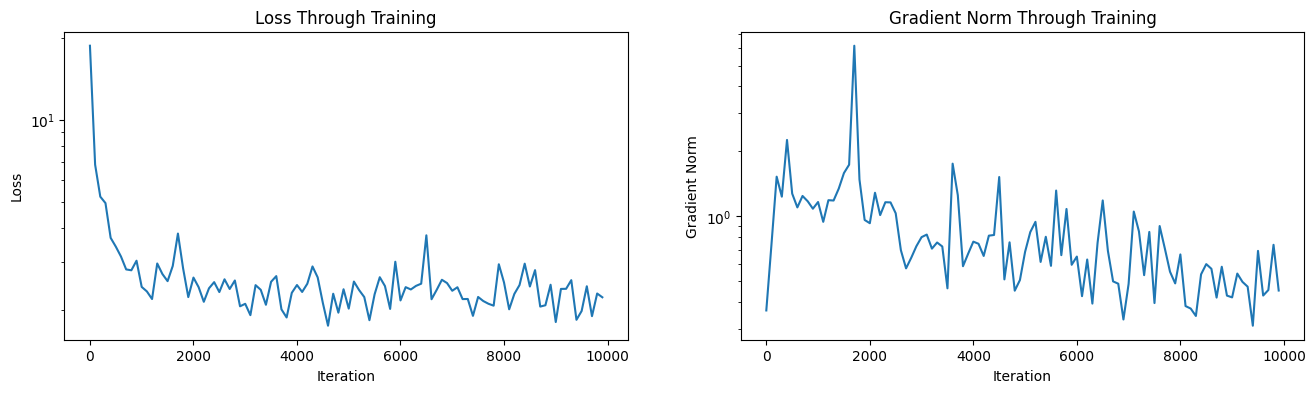

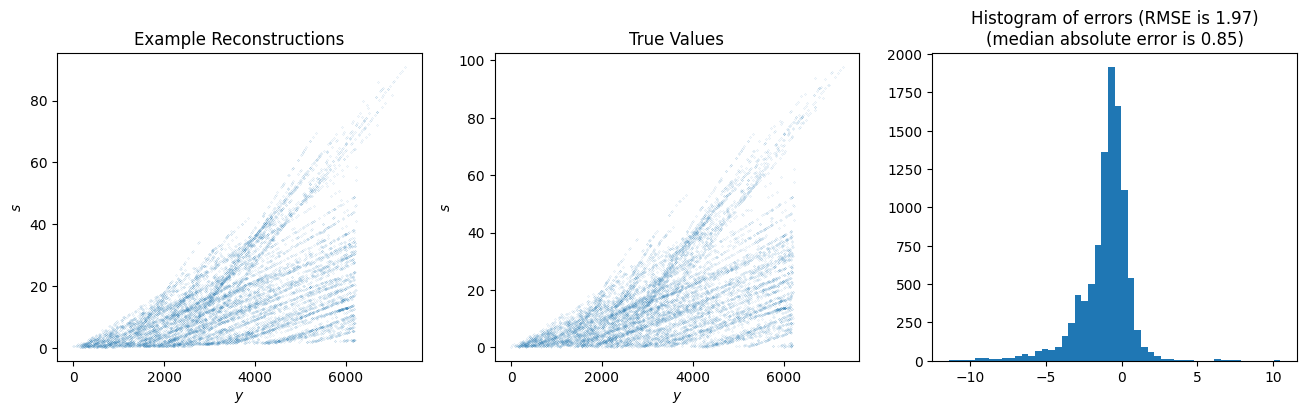

In [27]:
model.plot_training_log()
model.plot_predictions(init_batch)

## Membrane Design Optimization

In [37]:
%autoreload 2
from acquisition import MCAcquisition
from design_optimization import get_trajectory_posterior_fn, get_height_max_posterior_fn
from design_optimization import opt_var_to_phys_var, print_recommendations

#### New Optimization - Relevant to Membrane 6 (w/ log(3) scale factor)

In [38]:
# set target Forces and Pressures (they should be the same shape)
#target_Fs = jnp.array([5, 10, 15])
target_Fs = jnp.array([24.5, 24.5, 24.5])
target_Ps = jnp.array([4137, 5516, 6895])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [39]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))

Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [05:18<00:00, 15.69it/s]


In [40]:
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[0][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)

The recomendation is to make membranes with 0 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  25.40


In [41]:
print("Here are the recommendations considering all possibilities.")
for num_rings in [2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[0] : .2e}):')
    fs, ps, hs = posterior(recs[0], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[0][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)

Here are the recommendations considering all possibilities.

------------------

Using 2 rings (acquisition score is  5.91e-01):
Forces obtained are: [24.485842 24.48768  24.491833]
Pressures obtained are: [4138.062  5514.8677 6894.657 ]
Heights obtained are: [21.597628 43.43288  59.132034]

Membrane:
thickness:  2.00
contact radius:  25.40
Ring 1) radius:  33.40; width:  5.00
Ring 2) radius:  46.40; width:  5.00


# 2nd Design Optimization (go to high force high pressure)

In [42]:
# Using 2 rings (acquisition score is  7.14e-01):
# Forces obtained are: [39.244083 39.220383 39.22216 ]
# Pressures obtained are: [8277.179 8271.041 8271.795]
# Heights obtained are: [50.08479  50.0486   50.055122]

# Membrane:
# thickness:  2.00
# contact radius:  25.58
# Ring 1) radius:  46.80; width:  5.00
# Ring 2) radius:  59.82; width:  5.00


# With mean height maximization:
# Using 2 rings (acquisition score is  8.50e-01):
# Forces obtained are: [14.703299 24.485249 39.23942 ]
# Pressures obtained are: [8271.504 8274.059 8273.852]
# Heights obtained are: [69.991035 60.41282  48.178787]

# Membrane:
# thickness:  2.00
# contact radius:  31.72
# Ring 1) radius:  48.62; width:  5.00
# Ring 2) radius:  61.90; width:  5.01

In [43]:
# set target Forces and Pressures (they should be the same shape)
# target_Fs = jnp.array([39.24, 39.24, 39.24])
target_Fs = jnp.array([14.7, 24.5, 39.24])
target_Ps = jnp.array([8273, 8273, 8273])

# set constants for score (k_f and k_p should both be reasonably larger than k_h)
k_f = 5_000
k_p = 5_000
k_h = 1

# all target vectors should have the same shape: (num_targets,)
num_targets = len(target_Fs)
target_Fs.shape, target_Ps.shape

((3,), (3,))

In [44]:
q = 1 # this should always be 1
seed = 38 # change this to alter RNG of initial guesses

recs = []
objs = []
for num_rings in [2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    acquisition = MCAcquisition(vmap(posterior), bounds, acq_fn='EM')
    print(f"Determining best membranes to test using {num_rings} rings...")
    u_new = acquisition.next_best_point(q, num_restarts=5_000, seed=seed+5)
    recs.append(u_new.copy())
    objs.append(acquisition.evaluate(u_new[None,:]))
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome


Determining best membranes to test using 2 rings...


100%|██████████| 5000/5000 [07:23<00:00, 11.27it/s]


In [45]:
print(f'The recomendation is to make membranes with {best_num_rings} rings.')
print(f'Here are the recomendations:')
membrane_coef = opt_var_to_phys_var(recs[0][:2*(best_num_rings+1)], best_num_rings)[None,:]
print_recommendations(membrane_coef)
print("Here are the recommendations considering all possibilities.")
for num_rings in [2]:
    posterior, bounds = get_height_max_posterior_fn(model, num_rings, target_Fs, target_Ps, k_f, k_p, k_h)
    print('\n------------------\n')
    print(f'Using {num_rings} rings (acquisition score is {-objs[0] : .2e}):')
    fs, ps, hs = posterior(recs[0], return_predictions_only=True)
    print(f'Forces obtained are: {fs}')
    print(f'Pressures obtained are: {ps}')
    print(f'Heights obtained are: {hs}')
    #print(f'Heights obtained are: {recs[num_rings][-2*num_targets:-num_targets]}')
    #print(f'Pressures obtained are: {recs[num_rings][-num_targets:]}')
    membrane_coef = opt_var_to_phys_var(recs[0][:2*(num_rings+1)], num_rings)[None,:]
    print_recommendations(membrane_coef)
# plotting membrane plane
Ps = jnp.linspace(0,7_000, 101)
Hs = jnp.linspace(0, 80, 100)
PP, HH = jnp.meshgrid(Ps, Hs) # both shape (num_Hs, num_Ps)
PP = PP.reshape((-1,1))
HH = HH.reshape((-1,1))

# select best membrane
best_num_rings = int(jnp.argmin(jnp.array(objs))) # determine best outcome
membrane_coef = opt_var_to_phys_var(recs[best_num_rings][:2*(best_num_rings+1)], best_num_rings)[None,:]

us = jnp.concatenate([jnp.repeat(membrane_coef, len(PP), axis=0), HH], axis=-1)
ys = PP
FF = model.apply(model.params, us, ys)
FF = jnp.nanmean(FF, axis=0)

The recomendation is to make membranes with 0 rings.
Here are the recomendations:

Membrane:
thickness:  2.00
contact radius:  31.87
Here are the recommendations considering all possibilities.

------------------

Using 2 rings (acquisition score is  8.53e-01):
Forces obtained are: [14.69484  24.498964 39.239532]
Pressures obtained are: [8273.134 8272.604 8271.626]
Heights obtained are: [70.       60.813812 48.2874  ]

Membrane:
thickness:  2.00
contact radius:  31.87
Ring 1) radius:  46.32; width:  5.00
Ring 2) radius:  59.55; width:  5.00
